In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from scipy import stats

%matplotlib inline
# plt.style.use('ggplot')

# HELPER FUNCTIONS

In [2]:
def read_data(file_path, column_names):
    """Reads the data from the specified file and retrieves the column names
    
    Args:
        file_path: The path of the file as a String
        column_names: Array of Strings representing the names of the colunms
        
    Returns:
        A DataFrame of the read in data
    """
    data = pd.read_csv(file_path, header = 0, names = column_names)
    return data

def feature_normalize(dataset):
    """Normalizes the data in the DataFrame using the mean and sigma values
    
    Args:
        dataset: The DataFrame to normalize
        
    Returns:
        The normalized data
    """
    mu = np.mean(dataset, axis = 0)
    sigma = np.std(dataset, axis = 0)
    return (dataset - mu) / sigma

def basic_feature_normalize(dataset, cols_to_norm):
    """A Basic Normalization of the dataset
    
    Takes the dataset and normalizes it from 0 (min value) to 1 (max value)
    
    Args:
        dataset: The DataFrame to normalize
        cols_to_norm: An Array of strings of the columns that need normalization
        
    Returns:
        The normalized dataset with the specified columns normalized between 0 and 1
    """
    dataset[cols_to_norm] = dataset[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return dataset

def make_rgbs(dataset, cols_to_rgb):
    """Takes a dataset and converts specific columns into rgb values
    
    Args:
        dataset: The DataFrame to convert to rgb values
        cols_to_rgb: An Arrya of strings of the columns that need to be converted
        
    Returns:
        The dataset with the specified columns converted to rgb values
    """
    dataset[cols_to_rgb] = dataset[cols_to_rgb].apply(lambda x: int(x * 255))
    return dataset

def convert_timestamp(dataset):
    """Converts the timestamp to a unix timestamp
    
    Args:
        dataset: The DataFrame with the timestamp column to convert to unix
        
    Returns:
        The dataset with the converted timestamp
    """
    dataset['Timestamp'] = dataset['Timestamp'].apply(lambda x:
                                                     datetime.strptime(x, '%m/%d/%y %H:%M').timestamp())
    return dataset

def convert_BGA_RFU(dataset, threshold):
    """Converts the BGA_Phycocyanin_RFU column to a true or false value (represented by 1 or 0)
       based on the threshold value
       
    Args:
        dataset: The DataFrame with the BGA_Phycocyanin_RFU value to be adjusted
        threshold: The minimum value for an algae bloom to be true
        
    Returns:
        The dataset with the converted BGA_RFU value"""
    dataset['BGA_Phycocyanin_RFU'] = dataset['BGA_Phycocyanin_RFU'].apply(lambda x: 1 if x >= threshold else 0)
    return dataset

# Batch Creation

In [3]:
# We step 50% down based on window size
def windows(data, size):
    counter_output = 0
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 12)
        counter_output += 1
        if counter_output % 10 == 0:
            print('Window Segmentation {0:.2f}% done'.format((start / data.count()) * 100))
    
# 32 chosen for 8 hours of 15 minute intervals
# TODO: NEED TO PASS IN COLUMNS AND DETERMINE FROM THAT
def segment_signal(dataset, window_size = 90, columns = 5):
    segments = np.empty((0, window_size, columns))
    labels = np.empty((0))
    count = 0;
    for (start, end) in windows(dataset["Timestamp"], window_size):
        temperature = dataset['Temperature'][start:end]
        conductivity = dataset['Sp_Cond'][start:end]
        turbidity = dataset['Turbidity'][start:end]
        ph = dataset['pH'][start:end]
        odo = dataset['ODO'][start:end]
        if(len(dataset['Timestamp'][start:end]) == window_size):
            segments = np.vstack([segments, np.dstack([temperature, conductivity, turbidity, ph, odo])])
            labels = np.append(labels, stats.mode(dataset['BGA_Phycocyanin_RFU'][start:end])[0][0])
    return segments, labels

# Setup the Lake_Dataset

In [4]:
cols = ['Timestamp', 'Temperature', 'Sp_Cond', 'pH_mV', 'pH', 'Turbidity', 'Chlorophyll', 'Chlorophyll_RFU',
        'ODOSat', 'ODO', 'BGA_Phycocyanin_RFU']

cols_to_keep = []
cols_to_keep.append('Timestamp')
cols_to_keep.append('Temperature')
cols_to_keep.append('Sp_Cond')
# cols_to_keep.append('pH_mV')
cols_to_keep.append('pH')
cols_to_keep.append('Turbidity')
# cols_to_keep.append('Chlorophyll')
# cols_to_keep.append('Chlorophyll_RFU')
# cols_to_keep.append('ODOSat')
cols_to_keep.append('ODO')
cols_to_keep.append('BGA_Phycocyanin_RFU')

lake_dataset = read_data('./data/cleaned/utah_lake_vineyard.csv', cols) 

for col in cols:
    if col not in cols_to_keep:
        lake_dataset = lake_dataset.drop(col, axis=1)
        
lake_dataset = convert_timestamp(lake_dataset)
lake_dataset.head()

,Timestamp,Temperature,Sp_Cond,pH,Turbidity,ODO,BGA_Phycocyanin_RFU
0,1.493960e+09,15.02,1848,8.36,16.84,9.04,0.4
1,1.493961e+09,14.99,1847,8.36,16.76,9.04,0.4
2,1.493962e+09,14.96,1847,8.36,16.82,9.04,0.4
3,1.493963e+09,14.95,1848,8.36,17.19,9.03,0.4
4,1.493964e+09,14.92,1848,8.36,16.85,9.02,0.4


In [5]:
lake_dataset = convert_BGA_RFU(lake_dataset, 1.0)

In [6]:
normalized_lake_dataset = basic_feature_normalize(lake_dataset, ['Temperature', 'Sp_Cond', 'Turbidity', 'pH', 'ODO'])
normalized_lake_dataset.head()

,Timestamp,Temperature,Sp_Cond,pH,Turbidity,ODO,BGA_Phycocyanin_RFU
0,1.493960e+09,0.409329,0.853771,0.330769,0.025439,0.351818,0
1,1.493961e+09,0.408021,0.853309,0.330769,0.025313,0.351818,0
2,1.493962e+09,0.406713,0.853309,0.330769,0.025407,0.351818,0
3,1.493963e+09,0.406277,0.853771,0.330769,0.025989,0.350909,0
4,1.493964e+09,0.404969,0.853771,0.330769,0.025454,0.350000,0


In [7]:
normalized_lake_dataset['Temperature'].max()

1.0

In [8]:
normalized_lake_dataset['Temperature'].min()

0.0

In [9]:
normalized_lake_dataset['BGA_Phycocyanin_RFU'].max()

1

In [10]:
normalized_lake_dataset.shape

(18947, 7)

# Retrieve the segments and labels

In [11]:
segments, labels = segment_signal(normalized_lake_dataset, 36, 5)

Window Segmentation 0.16% done
Window Segmentation 0.32% done
Window Segmentation 0.48% done
Window Segmentation 0.63% done
Window Segmentation 0.79% done
Window Segmentation 0.95% done
Window Segmentation 1.11% done
Window Segmentation 1.27% done
Window Segmentation 1.43% done
Window Segmentation 1.58% done
Window Segmentation 1.74% done
Window Segmentation 1.90% done
Window Segmentation 2.06% done
Window Segmentation 2.22% done
Window Segmentation 2.38% done
Window Segmentation 2.53% done
Window Segmentation 2.69% done
Window Segmentation 2.85% done
Window Segmentation 3.01% done
Window Segmentation 3.17% done
Window Segmentation 3.33% done
Window Segmentation 3.48% done
Window Segmentation 3.64% done
Window Segmentation 3.80% done
Window Segmentation 3.96% done
Window Segmentation 4.12% done
Window Segmentation 4.28% done
Window Segmentation 4.43% done
Window Segmentation 4.59% done
Window Segmentation 4.75% done
Window Segmentation 4.91% done
Window Segmentation 5.07% done
Window S

Window Segmentation 41.48% done
Window Segmentation 41.64% done
Window Segmentation 41.80% done
Window Segmentation 41.96% done
Window Segmentation 42.12% done
Window Segmentation 42.28% done
Window Segmentation 42.43% done
Window Segmentation 42.59% done
Window Segmentation 42.75% done
Window Segmentation 42.91% done
Window Segmentation 43.07% done
Window Segmentation 43.23% done
Window Segmentation 43.38% done
Window Segmentation 43.54% done
Window Segmentation 43.70% done
Window Segmentation 43.86% done
Window Segmentation 44.02% done
Window Segmentation 44.18% done
Window Segmentation 44.33% done
Window Segmentation 44.49% done
Window Segmentation 44.65% done
Window Segmentation 44.81% done
Window Segmentation 44.97% done
Window Segmentation 45.13% done
Window Segmentation 45.28% done
Window Segmentation 45.44% done
Window Segmentation 45.60% done
Window Segmentation 45.76% done
Window Segmentation 45.92% done
Window Segmentation 46.08% done
Window Segmentation 46.23% done
Window S

Window Segmentation 82.81% done
Window Segmentation 82.97% done
Window Segmentation 83.13% done
Window Segmentation 83.28% done
Window Segmentation 83.44% done
Window Segmentation 83.60% done
Window Segmentation 83.76% done
Window Segmentation 83.92% done
Window Segmentation 84.08% done
Window Segmentation 84.23% done
Window Segmentation 84.39% done
Window Segmentation 84.55% done
Window Segmentation 84.71% done
Window Segmentation 84.87% done
Window Segmentation 85.03% done
Window Segmentation 85.18% done
Window Segmentation 85.34% done
Window Segmentation 85.50% done
Window Segmentation 85.66% done
Window Segmentation 85.82% done
Window Segmentation 85.98% done
Window Segmentation 86.14% done
Window Segmentation 86.29% done
Window Segmentation 86.45% done
Window Segmentation 86.61% done
Window Segmentation 86.77% done
Window Segmentation 86.93% done
Window Segmentation 87.09% done
Window Segmentation 87.24% done
Window Segmentation 87.40% done
Window Segmentation 87.56% done
Window S

In [12]:
segments.shape

(6304, 36, 5)

In [13]:
reshaped_segments = segments.reshape(len(segments), 1, 36, 5)
reshaped_segments.shape

(6304, 1, 36, 5)

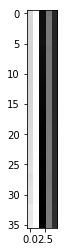

In [14]:
plt.imshow(reshaped_segments[1000][0] * 255, cmap='gray')

In [15]:
reshaped_segments_as_image = segments.reshape(len(segments), 6, 6, 5)

In [16]:
segments.shape

(6304, 36, 5)

In [17]:
reshaped_segments_as_image.shape

(6304, 6, 6, 5)

In [18]:
labels.shape

(6304,)

In [19]:
# labels = labels.reshape(len(labels), 1)

In [20]:
# labels.shape

In [21]:
new_labels = np.zeros((len(labels), 2))

In [22]:
new_labels.shape

(6304, 2)

In [23]:
new_labels[0][0]

0.0

In [24]:
iter = 0
while(iter < len(labels)):
    if labels[iter] > 0.0:
        print(iter)
    new_labels[iter][int(labels[iter])] = 1
    iter = iter + 1

273
274
275
276
277
278
279
280
281
282
283
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1

In [25]:
new_labels[1500:2000]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,

In [26]:
new_labels[0:100]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,

In [27]:
labels = new_labels

In [28]:
labels

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

# Break apart the training and test data

In [29]:
from sklearn.model_selection import train_test_split

class CNNHelper():
    
    def __init__(self):
        self.iterator = 0
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(reshaped_segments_as_image, labels, test_size=0.3, random_state=101)

    def next_batch(self, batch_size):
        x = self.X_train[self.iterator:self.iterator + batch_size]
        y = self.y_train[self.iterator:self.iterator + batch_size]
        self.iterator = (self.iterator + batch_size) % len(self.X_train)
        return x, y

# CREATE THE MODEL

In [30]:
x = tf.placeholder(tf.float32, shape=[None, 6, 6, 5])
y_true = tf.placeholder(tf.float32, shape=[None, 2])

In [31]:
hold_prob = tf.placeholder(tf.float32)

In [32]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [33]:
convo_1 = convolutional_layer(x,shape=[2,2,5,6])
convo_1_pooling = max_pool_2by2(convo_1)

In [34]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[2,2,6,12])
convo_2_pooling = max_pool_2by2(convo_2)

In [35]:
convo_2_flat = tf.reshape(convo_2_pooling, [-1, 4*12])

In [36]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,64))

In [37]:
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [38]:
full_one_dropout.shape

TensorShape([Dimension(None), Dimension(64)])

In [39]:
y_pred = normal_full_layer(full_one_dropout,2)
y_pred.shape

TensorShape([Dimension(None), Dimension(2)])

## Loss Function

In [40]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

In [41]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [42]:
init = tf.global_variables_initializer()
cnn_helper = CNNHelper()

In [43]:
cnn_helper.X_test.shape

(1892, 6, 6, 5)

In [44]:
cnn_helper.X_test[0]

array([[[ 0.5749782 ,  0.91763073,  0.47173134,  0.42307692,  0.18909091],
        [ 0.5793374 ,  0.91716798,  0.49248475,  0.42307692,  0.18545455],
        [ 0.58238884,  0.89958353,  0.49102258,  0.41538462,  0.18272727],
        [ 0.581517  ,  0.89958353,  0.528363  ,  0.41538462,  0.18363636],
        [ 0.58064516,  0.89819528,  0.53306396,  0.41538462,  0.18363636],
        [ 0.58064516,  0.90189727,  0.52944783,  0.41538462,  0.18636364]],

       [[ 0.58108108,  0.90652476,  0.55636438,  0.41538462,  0.18636364],
        [ 0.57890148,  0.9106895 ,  0.5577165 ,  0.41538462,  0.18909091],
        [ 0.57802964,  0.91207774,  0.5577165 ,  0.41538462,  0.19      ],
        [ 0.57585004,  0.91577973,  0.58389409,  0.41538462,  0.19181818],
        [ 0.57628596,  0.91716798,  0.56215018,  0.41538462,  0.19454545],
        [ 0.5771578 ,  0.91439149,  0.56329791,  0.41538462,  0.19363636]],

       [[ 0.57672188,  0.91439149,  0.61592038,  0.41538462,  0.19454545],
        [ 0.57672188,

In [45]:
# cnn_helper.X_test = np.zeros((1892, 6, 6, 3))
# cnn_helper.X_test[0]

In [46]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cost_history = []
    acc_history = []

    for i in range(4000):
        batch = cnn_helper.next_batch(100)
        _, c = sess.run([train, cross_entropy], feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})
        cost_history.append(c)
        
        matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
        acc = tf.reduce_mean(tf.cast(matches,tf.float32))
        acc_history.append(acc)
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:cnn_helper.X_test,y_true:cnn_helper.y_test,hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
0.612579


Currently on step 100
Accuracy is:
0.650106


Currently on step 200
Accuracy is:
0.838266


Currently on step 300
Accuracy is:
0.846723


Currently on step 400
Accuracy is:
0.849366


Currently on step 500
Accuracy is:
0.857294


Currently on step 600
Accuracy is:
0.861522


Currently on step 700
Accuracy is:
0.876321


Currently on step 800
Accuracy is:
0.876321


Currently on step 900
Accuracy is:
0.865222


Currently on step 1000
Accuracy is:
0.886892


Currently on step 1100
Accuracy is:
0.880021


Currently on step 1200
Accuracy is:
0.873679


Currently on step 1300
Accuracy is:
0.890063


Currently on step 1400
Accuracy is:
0.874207


Currently on step 1500
Accuracy is:
0.89112


Currently on step 1600
Accuracy is:
0.897463


Currently on step 1700
Accuracy is:
0.895877


Currently on step 1800
Accuracy is:
0.894292


Currently on step 1900
Accuracy is:
0.885835


Currently on step 2000
Accuracy is:
0.897463


Currently on step 2100
Acc

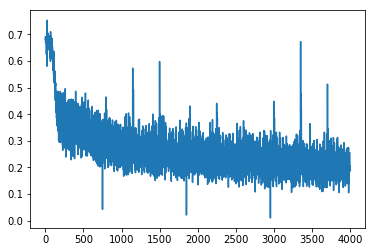

In [51]:
plt.plot(cost_history)
# plt.plot(acc_history)
# plt.figure(figsize=(20,10))
# acc_history